# Decision Tree Classifier Experimentation
Created by: Patrick Liu :)

## Jupyter Notebook Tutorial
- Jupyter notebook is a really great way of running data science programs, as we can choose to only execute certain blocks of code, as well as add notes like I'm doing right now.
- To run all cells, click the "Cells" tab up top and click "Run All"
- To run the current cell you are entering, simply click "Run Cell" or "shift-enter"

## Imports

In [3]:
import numpy as np # math operations
import pandas as pd # data processing
import matplotlib.pyplot as plt # simple data visualization library
import seaborn as sns # statistical data visualization
%matplotlib inline 
# makes plots not annoying :)

## Exploratory Data Analysis
- To learn more about how pandas dataframes work, check out this link here: https://pandas.pydata.org/docs/user_guide/index.html
    - There's a lot here, so if you just want a quick start on pandas, refer to this link here: https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html

In [6]:
df = pd.read_csv('./car_evaluation.csv',header=None) # loading csv into pandas dataframe
df.head() # good method to preview dataset

,0,1,2,3,4,5,6
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


Notice that these column names are not descriptive at all, let's rename them!

In [8]:
col_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
df.columns = col_names # Rename columns
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [10]:
df.info() # another good method to preview dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
buying      1728 non-null object
maint       1728 non-null object
doors       1728 non-null object
persons     1728 non-null object
lug_boot    1728 non-null object
safety      1728 non-null object
class       1728 non-null object
dtypes: object(7)
memory usage: 94.6+ KB


In [11]:
for col in col_names:
    print(df[col].value_counts()) # can index into dataframe using column, just like array
# prints number of values for each column, and the attribute types that they can take per column

vhigh    432
med      432
low      432
high     432
Name: buying, dtype: int64
vhigh    432
med      432
low      432
high     432
Name: maint, dtype: int64
4        432
2        432
5more    432
3        432
Name: doors, dtype: int64
4       576
more    576
2       576
Name: persons, dtype: int64
med      576
big      576
small    576
Name: lug_boot, dtype: int64
med     576
low     576
high    576
Name: safety, dtype: int64
unacc    1210
acc       384
good       69
vgood      65
Name: class, dtype: int64


A really common problem with datasets is that they have null/missing values, which can cause a lot of problems when performing analysis. Fortunately, since this dataset is curated for educational purposes, there are no missing/null values:

In [12]:
df.isnull().sum()

buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64

Now, we are defining our input features and our output that we want to predict/classify. In this case, our inputs are every column from the dataframe, and our output that we want to predict/classify given our feature input is "class."

In [13]:
X = df.drop(['class'], axis=1) # all columns except "class" as input feature vector
y = df['class'] # output target variable

## Experiment 1: Changing Train/Test Split Ratio
- Since decision trees are a suprevised learning approach, we want to split the data we are given into training (data we will use to train/create our tree), and testing (data we will use to test our model and evaluate its accuracy)
- For this block of code, I want you guys to change the ratio for the train/test split: these values range from 0.0 to 1.0, corresponding to the proportion of data that will be used for testing, and see how it affects the accuracy of your model at the very end!
- documentation for train_test_split method: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
############################### TODO: Change test_size parameter! ###############################

In [18]:
# check number of values in train and test set
print(X_train.shape[0])
print(X_test.shape[0])

1157
571


## Feature Engineering
- Our goal is to encode our categorical variables in order to make them easier to work with when making our model

In [19]:
# initial types of data in train dataset
X_train.dtypes

buying      object
maint       object
doors       object
persons     object
lug_boot    object
safety      object
dtype: object

If you get an error running the cell below, try running `pip install category-encoders` in your terminal.

In [21]:
# Encode columns
import category_encoders as ce # library for encoding
encoder = ce.OrdinalEncoder(cols=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'])
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [22]:
# Let's see the results of our encoding!
X_train.head()

,buying,maint,doors,persons,lug_boot,safety
48,1,1,1,1,1,1
468,2,1,1,2,2,1
155,1,2,1,1,2,2
1721,3,3,2,1,2,2
1208,4,3,3,1,2,2


As you can see, instead of object values as attributes, we have converted all of them to a corresponding integer using an object to integer mapping

In [23]:
X_test.head() # Same for test dataset

,buying,maint,doors,persons,lug_boot,safety
599,2,2,4,3,1,2
1201,4,3,3,2,1,3
628,2,2,2,3,3,3
1498,3,2,2,2,1,3
1263,4,3,4,1,1,1


## Model Building!
- Now, we are going to build our decision tree classifer!

In [24]:
# import DecisionTreeClassifier

from sklearn.tree import DecisionTreeClassifier

## GINI Index vs Entropy
- Remember in our workshop, how I talked about how we determine what the best question to ask is? I talked about entropy and information gain. Well, it turns out there is another way to determine this: GINI.
### What Is GINI Index?
- GINI is simply another way of determining the best question to ask
    - In the most simplified sense, GINI measures how often a randomly chosen element from the set would be incorrectly classified
- Comparison of GINI and Entropy equations:
    - GINI: $1- \sum_i p_i^2$ where $p_i$ is the probability of each outcome after asking our question
    - Entropy: $H(S) = -\sum_{y_i}p(y_i)\log p(y_i)$ where $p_i$ is the probability of each outcome after asking our question
- At the end of the day, both of these metrics for computing best question are extremely similar, but note that since GINI does not require a log operation to calculate, it can be more computationally efficient (albeit marginally so)

## Experiment 2 & 3
- Train your decision tree classifier using the GINI index and Entropy and compare your results!
- Experiment with changing the max_depth of your tree, and see how it changes your model's accuracy!

In [25]:
# GINI Index 
clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)
# fit the model
clf_gini.fit(X_train, y_train)

# # Uncomment me to test using entropy instead!
# clf_en = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)


# # fit the model
# clf_en.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

Change the variable names below corresponding to if you are training your using entropy or GINI Index

In [26]:
# Predict the test set results
y_pred_gini = clf_gini.predict(X_test)

In [27]:
from sklearn.metrics import accuracy_score

print('Model accuracy score with GINI index: {0:0.4f}'. format(accuracy_score(y_test, y_pred_gini)))

Model accuracy score with GINI index: 0.8021


## Checking For Overfitting
- Overfitting is when our model only classifies our data that we give it well, but not any new data that we give it well at all. To see if we are overfitting, we can compare our train and test set accuracies and see if they are similar. If not, then our model has most likely been overfitted

In [28]:
print('Training set score: {:.4f}'.format(clf_gini.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(clf_gini.score(X_test, y_test)))

Training set score: 0.7865
Test set score: 0.8021


Our train and test set have extremely similar accuracies, so our data is not overfitted.
## Visualize Our Tree!
- If this cell errors, you must install the graphviz package on your computer
- For Mac, install homebrew by pasting this command in your terminal: `/bin/bash -c "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/install.sh)"`
    - then, run `brew install graphviz` and you are done!
- For Windows, run `pip3 install graphviz`
    - then, uncomment the code below this

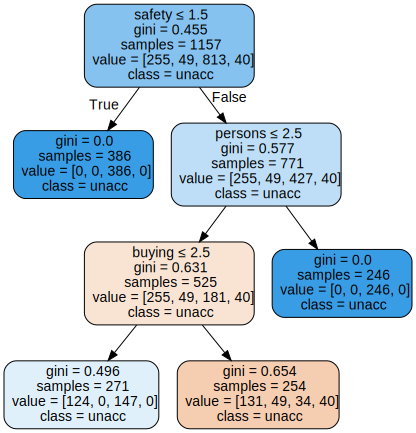

In [32]:
# import os
# os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
import graphviz 
dot_data = tree.export_graphviz(clf_gini, out_file=None, 
                              feature_names=X_train.columns,  
                              class_names=y_train,  
                              filled=True, rounded=True,  
                              special_characters=True)

graph = graphviz.Source(dot_data) 

graph 

### Interpreting the Tree
- Layout of each node:
    - Top: Question that is asked (for top node, question is: Is safety $\leq$ 1.5?)
    - gini/entropy: gini index calculation
    - samples: number of samples in set
    - Value: Number of samples in each category for output we are classifying
    - Bottom: Classification of our output variable for that node